In [1]:
sample='LL653-E1-P1-TC_S17' #f'LL719-P1-CC_S1' , 
template='Tigre'
data_path=f'/n/groups/klein/shouwen/lili_project/DATA/CARLIN/20220717_SC_3A/TC' # path to CARLIN data folder
output_dir=f'/n/groups/klein/shouwen/lili_project/DATA/CARLIN/20220717_SC_3A/TC/CARLIN/Shouwen_Method/{sample}'
CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg='scLimeCat' # ['sc10xV3',  'scLimeCat']
coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.8
seq_3prime_upper_N=None
seq_5prime_upper_N=None

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from carlinhf import CARLIN as car
from carlinhf import larry
import importlib
importlib.reload(car)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Single-cell CARLIN pipeline for scLimeCat

In [3]:
CARLIN_dir=data_path+f'/CARLIN/results_cutoff_override_{CARLIN_read_cutoff}'

In [4]:
ref_name=cfg[2:]
df_ref_BC=pd.read_csv(f'/n/groups/klein/shouwen/lili_project/packages/snakemake_carlin/source/{ref_name}_barcodes.txt.gz',
                      sep='\t',header=None,names=['CB'],compression='gzip')

In [5]:
%%time
## load sequences
df_raw_reads=car.CARLIN_raw_reads(data_path+'/raw_fastq',sample,protocol=cfg)

CPU times: user 50.2 s, sys: 983 ms, total: 51.2 s
Wall time: 51.5 s


In [18]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

0.0021024144006946783

In [19]:
df_N

,Seq,cell_bc,library,cell_id,umi,umi_id,clone_id
133,GCTAACGATTTATGTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,GCTAACGATTTATGTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...
835,TTTGACAGCATCGTTAGTTGATGGCGAAAGGTCGCAAAGTAAGAGC...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,TTTGACAGCATCGTTAGTTGATGGCGAAAGGTCGCAAAGTAAGAGC...
889,AAAACTGACGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCA...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,AAAACTGACGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCA...
1356,GCTACAGTAACTTTTCCCAGCCTCAATCTCATCTCTCTTTTTGCGT...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,GCTACAGTAACTTTTCCCAGCCTCAATCTCATCTCTCTTTTTGCGT...
1409,TTAGTAAGCTCTTTTTGATTCTCAAATCCGGCGTCAACCATACCAG...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,TTAGTAAGCTCTTTTTGATTCTCAAATCCGGCGTCAACCATACCAG...
...,...,...,...,...,...,...,...
1063751,TACTCCATCTTCTTCGGCACCTGTTTTACAGACACCTAAAGCTACA...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,TACTCCATCTTCTTCGGCACCTGTTTTACAGACACCTAAAGCTACA...
1064413,NNNNNNNNNNNNNNNNNNNNNNNNNNNN,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,NNNNNNNNNNNNNNNNNNNNNNNNNNNN
1064645,GGAGGCCTCCACTATGAAATCGCGTAGAGGCTTTGCTATTCAGCGT...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,GGAGGCCTCCACTATGAAATCGCGTAGAGGCTTTGCTATTCAGCGT...
1065759,AAAAGATTGATTGTGAGGTTATAACGCCGAAGCGGTAAAAATTTTA...,NNNNNNNN,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_NNNNNNNN,NNNNNNNN,NNNNNNNN_NNNNNNNN,AAAAGATTGATTGTGAGGTTATAACGCCGAAGCGGTAAAAATTTTA...


In [6]:
%%time
df_filter_reads=car.CARLIN_preprocessing(df_raw_reads,template=template,ref_cell_barcodes=df_ref_BC['CB'],
                                         seq_3prime_upper_N=seq_3prime_upper_N,seq_5prime_upper_N=seq_5prime_upper_N)

Total fastq: 1066393
Fastq with vaid 3 and 5 prime: 826174 (0.77)
Fastq with valid barcodes: 740886 (0.69)
CPU times: user 7.44 s, sys: 570 ms, total: 8.01 s
Wall time: 8 s


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

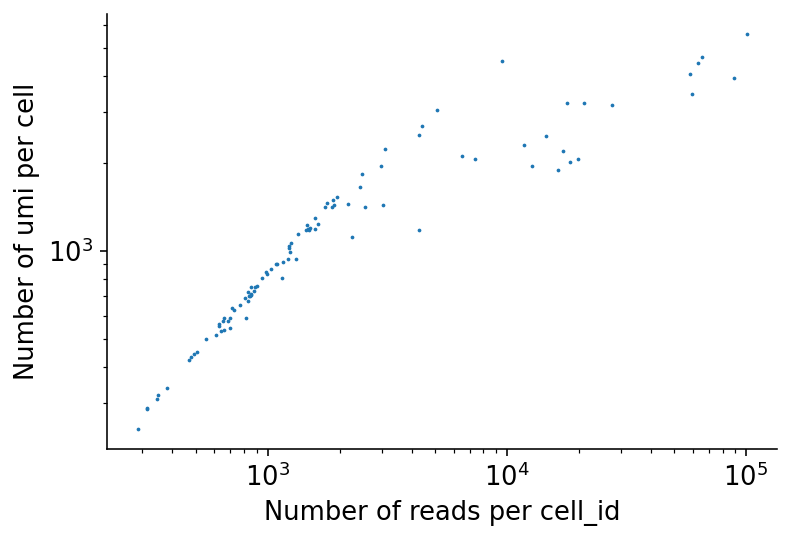

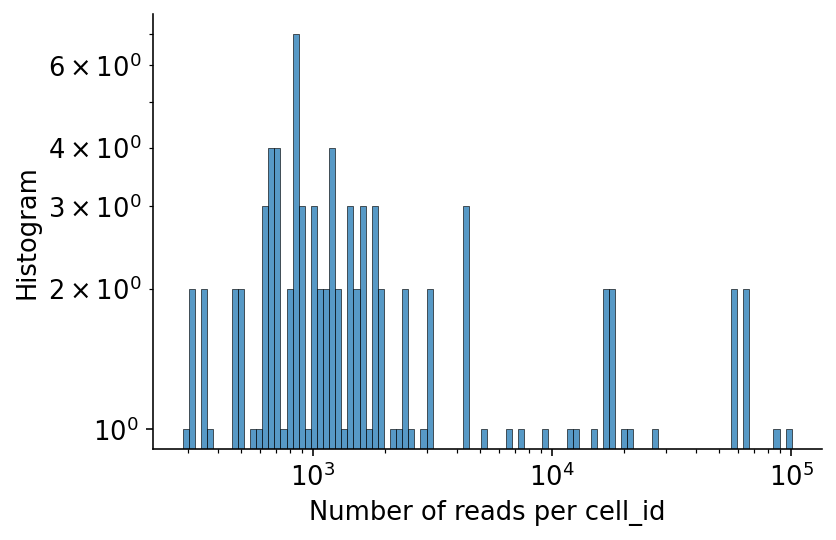

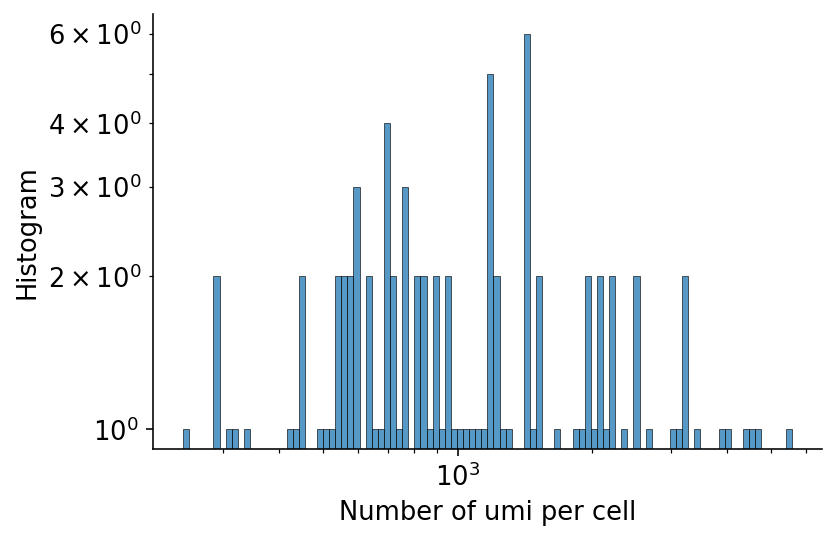

In [7]:
df_read=larry.QC_read_per_molecule(df_filter_reads,target_keys=["umi"])

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. For example, for scLimeCat, we only expect around 386cells, and ~300 clones

/n/groups/klein/shouwen/miniconda/miniconda_py37/envs/CoSpar_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/n/groups/klein/shouwen/miniconda/miniconda_py37/envs/CoSpar_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


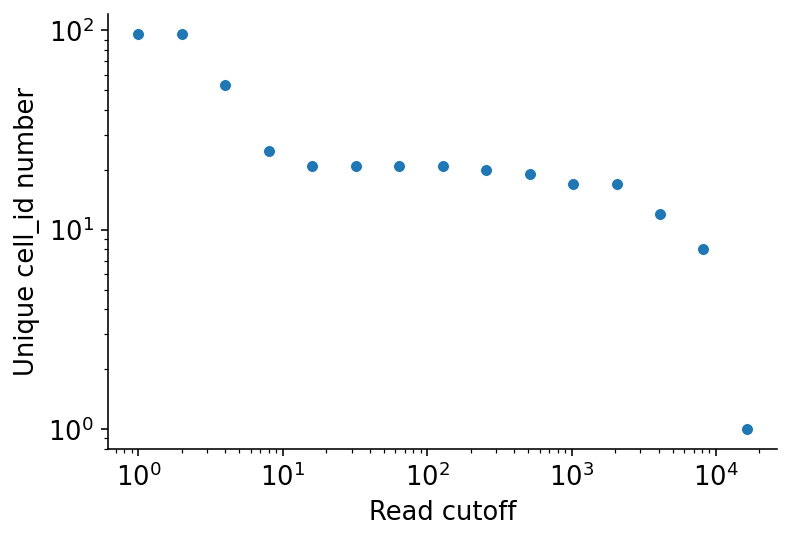

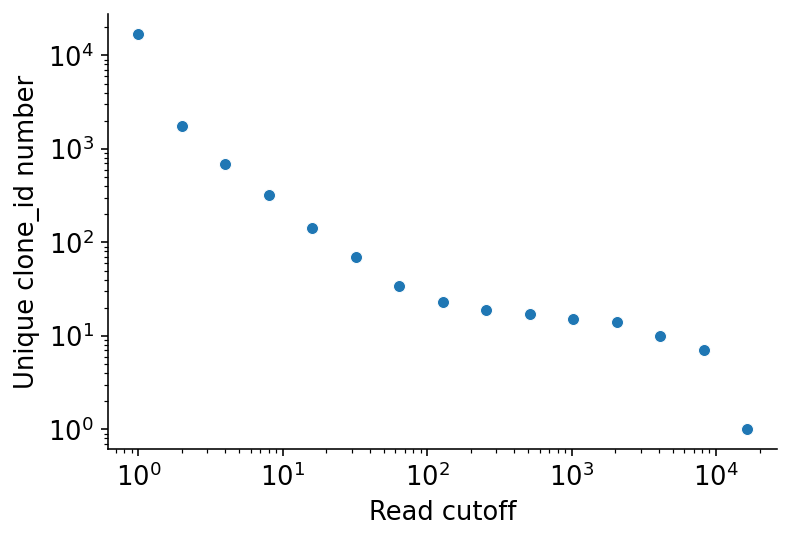

In [8]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [9]:
df_filter_reads

,cell_bc,library,cell_id,umi,umi_id,clone_id,read
0,TGAAGAGA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_TGAAGAGA,TGGTAGAG,TGAAGAGA_TGGTAGAG,TCGCCGGAGTCGTGACGCTGACGCATATGGAGTCGACACGACTCGC...,1
1,CGACACAC,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CGACACAC,GGGGGTTA,CGACACAC_GGGGGTTA,TCGCCGGAGTCGAGACGCTGACGGGATATGGAGTCGACACGACTCG...,14
15,TGAAGAGA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_TGAAGAGA,GAATTATG,TGAAGAGA_GAATTATG,TCGCCGGAGTCGTGACGCTGACGCATATGGAGTCGACACGACTCGC...,4
19,TGAAGAGA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_TGAAGAGA,TAAATATT,TGAAGAGA_TAAATATT,TCGCCGGAGTCGTGACGCTGACGCATATGGAGTCGACACGACTCGC...,3
22,CGACACAC,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CGACACAC,GGGGGTTA,CGACACAC_GGGGGTTA,TCGCCGGAGTCGTGACGCTGACGGGATATGGAGTCGCCACGACTCG...,1
...,...,...,...,...,...,...,...
740880,GTCGTAGA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_GTCGTAGA,GTAGCTTA,GTCGTAGA_GTAGCTTA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,1
740881,CATACCAA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CATACCAA,TAAGATAG,CATACCAA_TAAGATAG,TCGCCGGAGTCGAGACGCTGACGGGATATGGAGTCGACACGACTCG...,1
740882,ACACAGAA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_ACACAGAA,GGGGATAA,ACACAGAA_GGGGATAA,TCGCCGGAGTCGAGACGCTGACGCATATGGAGTCGACACGACTCGC...,1
740883,GGTGCGAA,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_GGTGCGAA,GATGTTTG,GGTGCGAA_GATGTTTG,TCGCCGGAGTCGAGACGCTGACGCATATGGAGTCGACACGACTCGC...,1


In [10]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 96
clone_id number: 16939
umi_id number: 134408
total reads: 741K


Plot distribution of unique clone barcode length. This informs how computationally expensive the following operation will be

In [ ]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=df_filter_reads['bc_length'] #list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Raw CARLIN length dist (UMI): {len(unique_bc_length)} count')

Text(0.5, 1.0, 'Unique CARLIN length dist: 109 count')

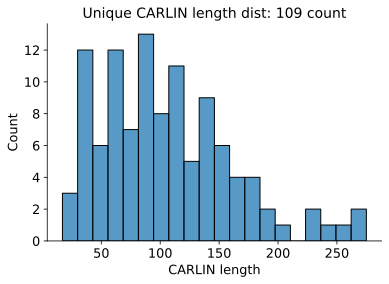

In [11]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=20)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Unique CARLIN length dist: {len(unique_bc_length)} count')

Denoise the clone id per each clone barcode length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at coarse_grained_readcutoff_floor

## Collapse clone_id and filter cells within the same clone_id length

In [12]:
read_cutoff=1 # initial read count filtering 
# coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
def filter_low_read_cells(df):
    coarse_grained_readcutoff=np.max([coarse_grained_readcutoff_floor,0.05*df['read'].max()])
    df_out=larry.remove_cells(df,read_cutoff=coarse_grained_readcutoff)
    return df_out

df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        read_cutoff=read_cutoff,
        distance_threshold=int(target_length*distance_relative_threshold),  
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_out=df_HQ_group.groupby('clone_id').apply(filter_low_read_cells).reset_index(drop=True)
    df_out['bc_length']=target_length
    df_list.append(df_out)
df_denoise_bc_1=pd.concat(df_list)

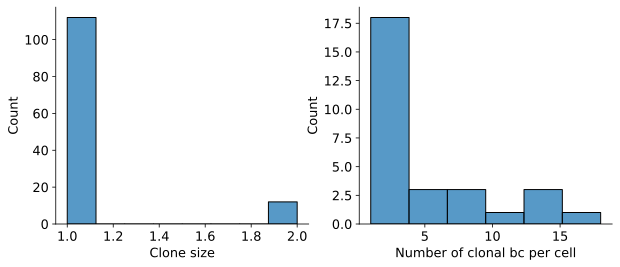

In [13]:
larry.QC_clonal_reports(df_denoise_bc_1)

In [14]:
larry.print_statistics(df_denoise_bc_1)

library number: 1
cell_id number: 29
clone_id number: 124
total reads: 587K


## Collapse clone_id within 1bp sequence length

It is also possible that there are insertion and deletion events. We group neighboring sequences within the distance cutoff, and when the neighboring sequence read is 10% of the source reads

Currently cleaning clone_id; number of unique elements: 124
Processing 124 unique sequences


 87%|████████▋ | 108/124 [00:06<00:01, 15.46it/s]


Number of unique elements (after cleaning): 109
Retained read fraction (above cutoff 0): 1.00
Retained read fraction (above cutoff 5): 1.00


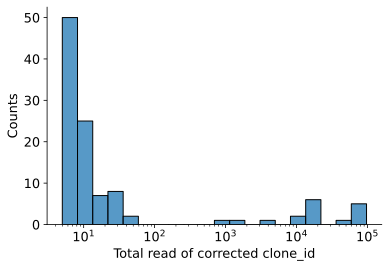

In [15]:
# this step is a lot slower because we need to align two sequences
df_denoise_bc_2=larry.denoise_clonal_data(
    df_denoise_bc_1,
    target_key="clone_id",
    read_cutoff=5,
    per_sample=None,
    denoise_method="alignment",
    distance_threshold=1,
    whiteList=None,
    plot_report=True,
)

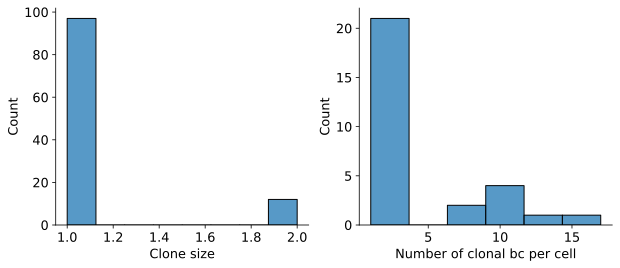

In [16]:
larry.QC_clonal_reports(df_denoise_bc_2)

In [17]:
larry.print_statistics(df_denoise_bc_2)

library number: 1
cell_id number: 29
clone_id number: 109
total reads: 587K


## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

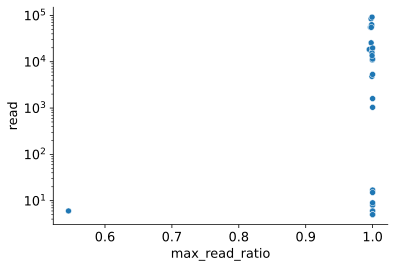

In [18]:
# select dominant barcode sequence within each cell barcode, we use a very high read_ratio to avoid false positive
#df_dominant_frac=car.calculate_read_fraction_for_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
df_dominant=car.obtain_read_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
sns.scatterplot(data=df_dominant,x='max_read_ratio',y='read')
plt.yscale('log')

Further filter out the cells where there is no clear dominant clone barcodes

In [19]:
#read_ratio_threshold=0.8
df_final=df_dominant[df_dominant['max_read_ratio']>read_ratio_threshold]

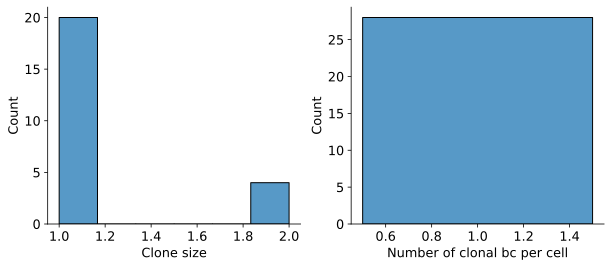

In [20]:
larry.QC_clonal_reports(df_final)

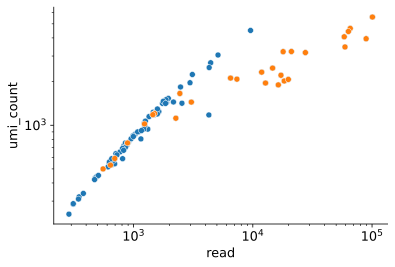

In [21]:
df_plot=df_filter_reads.groupby(['cell_id']).agg(read=('read','sum'),umi_count=('umi',lambda x: len(set(x)))).reset_index()
sns.scatterplot(data=df_plot,x='read',y='umi_count')
sns.scatterplot(data=df_plot[df_plot['cell_id'].isin(df_final['cell_id'])],x='read',y='umi_count')
#plt.plot([2*10**2,10**4],[2*10**2,0.6*10**4])
plt.xscale('log')
plt.yscale('log')

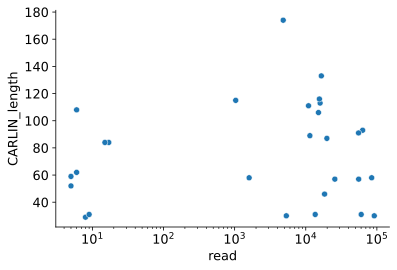

In [22]:
# sns.scatterplot(data=df_filter_reads,x='bc_length',y='read')
sns.scatterplot(data=df_final,y='CARLIN_length',x='read')
plt.xscale('log')

In [23]:
larry.print_statistics(df_final)

library number: 1
cell_id number: 28
clone_id number: 24
total reads: 586K


In [24]:
df_final.sort_values('CARLIN_length')

,clone_id,cell_id,library,cell_bc,CARLIN_length,read,max_read_ratio
2,TCGCCGGAGTCGACACGACTCGCTATGGA,LL653-E1-P1-TC_S17_CTGGCATA,LL653-E1-P1-TC_S17,CTGGCATA,29,8,1.000000
13,TCGCCGGAGTCGAGACGCTGACGCTATGGA,LL653-E1-P1-TC_S17_GCCAAGAC,LL653-E1-P1-TC_S17,GCCAAGAC,30,5331,1.000000
12,TCGCCGGAGTCGAGACGCTGACGCTATGGA,LL653-E1-P1-TC_S17_CTCAATGA,LL653-E1-P1-TC_S17,CTCAATGA,30,91914,0.999196
22,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,LL653-E1-P1-TC_S17_CTGTAGCC,LL653-E1-P1-TC_S17,CTGTAGCC,31,13576,0.999190
23,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,LL653-E1-P1-TC_S17_GTCTGTCA,LL653-E1-P1-TC_S17,GTCTGTCA,31,60200,0.998640
26,TCGCCGGAGTCGAGACGCTGAGAAATATGGA,LL653-E1-P1-TC_S17_AAGACGGA,LL653-E1-P1-TC_S17,AAGACGGA,31,9,1.000000
1,TCGCCGGAGTCGACACGACTCGCGCATAGCGATGGAGTACTATGGA,LL653-E1-P1-TC_S17_TGGTGGTA,LL653-E1-P1-TC_S17,TGGTGGTA,46,18388,0.994914
15,TCGCCGGAGTCGAGACGCTGACGGAGTCGACACGACTCGCGCATAC...,LL653-E1-P1-TC_S17_GGAGAACA,LL653-E1-P1-TC_S17,GGAGAACA,52,5,1.000000
4,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,LL653-E1-P1-TC_S17_GTCGTAGA,LL653-E1-P1-TC_S17,GTCGTAGA,57,25649,0.997821
3,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,LL653-E1-P1-TC_S17_CGCATACA,LL653-E1-P1-TC_S17,CGCATACA,57,55478,0.996766


In [27]:
df_final.to_csv(f'{output_dir}/called_barcodes_by_SW_method.csv',index=0)

## Compare with CARLIN pipeline

In [28]:
df_ref=car.extract_CARLIN_info(CARLIN_dir,[sample])

In [29]:
us_unique=set(df_final['clone_id'])
orig_pipeline_unique=set(df_ref['CARLIN'])
BC_insersect=us_unique.intersection(orig_pipeline_unique)
print(f'Dected unique clones by our method: {len(us_unique)}; by CARLIN pipeline: {len(orig_pipeline_unique)}; intersection: {len(BC_insersect)}')

Dected unique clones by our method: 24; by CARLIN pipeline: 17; intersection: 17


In [30]:
df_ref_flat=car.CARLIN_output_to_cell_by_barcode_long_table(df_ref)
df_ref_flat_new=df_ref_flat.merge(df_filter_reads,on=['cell_bc','clone_id']).groupby(
        ['cell_id','cell_bc','clone_id']).agg(read=('read','sum'),CARLIN_length=('bc_length','mean')).reset_index()
df_ref_flat_new['method']='CARLIN_pipeline'

df_joint=df_final.merge(df_ref_flat_new,on=['cell_id','cell_bc','clone_id'],how='inner').set_index('cell_id')
df_ref_flat_new=df_ref_flat_new.set_index('cell_id')
df_ref_flat_new.loc[df_joint.index,'read']=df_joint['read_x']
df_ref_flat_new=df_ref_flat_new.reset_index()

Text(0, 0.5, 'CARLIN sequence length')

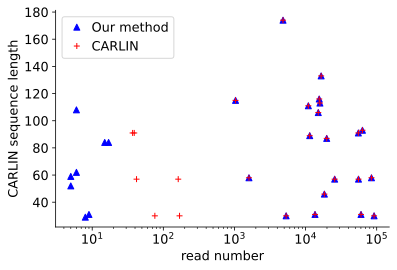

In [31]:
plt.plot(df_final['read'],df_final['CARLIN_length'],'^b',label='Our method')
plt.plot(df_ref_flat_new['read'],df_ref_flat_new['CARLIN_length'],'+r',label='CARLIN')
plt.xscale('log')
plt.legend()
plt.xlabel('read number')
plt.ylabel('CARLIN sequence length')

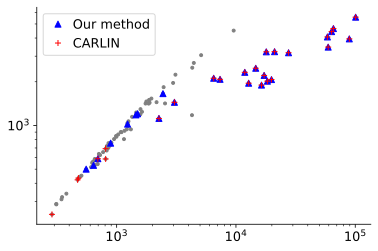

In [32]:
df_plot=df_filter_reads.groupby(['cell_id']).agg(read=('read','sum'),umi_count=('umi',lambda x: len(set(x)))).reset_index()
plt.plot(df_plot['read'],df_plot['umi_count'],'.',color='grey')
df_tmp=df_plot[df_plot['cell_id'].isin(df_final['cell_id'])]
plt.plot(df_tmp['read'],df_tmp['umi_count'],'^b',label='Our method')
df_tmp=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])]
plt.plot(df_tmp['read'],df_tmp['umi_count'],'+r',label='CARLIN')
#sns.scatterplot(data=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])],x='read',y='umi_count')
#plt.plot([2*10**2,10**4],[2*10**2,0.6*10**4])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Read number')
plt.ylabel('UMI count')
plt.legend()

In [79]:
df_final['method']='SW'
df_outer_joint=df_final.merge(df_ref_flat_new.drop(['read','CARLIN_length'],axis=1),on=['cell_id','cell_bc','clone_id'],
               how='outer').sort_values('CARLIN_length')
only_df_ref=df_ref_flat_new[df_ref_flat_new.cell_id.isin(df_outer_joint[pd.isna(df_outer_joint['library'])]['cell_id'])].set_index('cell_id')
df_outer_joint=df_outer_joint.set_index('cell_id')
for x in ['CARLIN_length','read']:
    df_outer_joint.loc[only_df_ref.index,x]=only_df_ref[x]
df_outer_joint=df_outer_joint.reset_index()
df_outer_joint

,cell_id,clone_id,library,cell_bc,CARLIN_length,read,max_read_ratio,method_x,method_y
0,LL653-E1-P1-TC_S17_CTGGCATA,TCGCCGGAGTCGACACGACTCGCTATGGA,LL653-E1-P1-TC_S17,CTGGCATA,29.0,8.0,1.000000,SW,NaN
1,LL653-E1-P1-TC_S17_GCCAAGAC,TCGCCGGAGTCGAGACGCTGACGCTATGGA,LL653-E1-P1-TC_S17,GCCAAGAC,30.0,5331.0,1.000000,SW,CARLIN_pipeline
2,LL653-E1-P1-TC_S17_CTCAATGA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,LL653-E1-P1-TC_S17,CTCAATGA,30.0,91914.0,0.999196,SW,CARLIN_pipeline
3,LL653-E1-P1-TC_S17_CTGTAGCC,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,LL653-E1-P1-TC_S17,CTGTAGCC,31.0,13576.0,0.999190,SW,CARLIN_pipeline
4,LL653-E1-P1-TC_S17_GTCTGTCA,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,LL653-E1-P1-TC_S17,GTCTGTCA,31.0,60200.0,0.998640,SW,CARLIN_pipeline
5,LL653-E1-P1-TC_S17_AAGACGGA,TCGCCGGAGTCGAGACGCTGAGAAATATGGA,LL653-E1-P1-TC_S17,AAGACGGA,30.0,76.0,1.000000,SW,NaN
6,LL653-E1-P1-TC_S17_TGGTGGTA,TCGCCGGAGTCGACACGACTCGCGCATAGCGATGGAGTACTATGGA,LL653-E1-P1-TC_S17,TGGTGGTA,46.0,18388.0,0.994914,SW,CARLIN_pipeline
7,LL653-E1-P1-TC_S17_GGAGAACA,TCGCCGGAGTCGAGACGCTGACGGAGTCGACACGACTCGCGCATAC...,LL653-E1-P1-TC_S17,GGAGAACA,52.0,5.0,1.000000,SW,NaN
8,LL653-E1-P1-TC_S17_GTCGTAGA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,LL653-E1-P1-TC_S17,GTCGTAGA,57.0,25649.0,0.997821,SW,CARLIN_pipeline
9,LL653-E1-P1-TC_S17_CGCATACA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,LL653-E1-P1-TC_S17,CGCATACA,57.0,55478.0,0.996766,SW,CARLIN_pipeline


In [80]:
df_outer_joint.to_csv(f'{output_dir}/df_outer_joint.csv',index=0)